<a href="https://colab.research.google.com/github/rangaraju1/ML-Projects/blob/main/EasyVisa_Full_Code_Solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EasyVisa: Visa Approval Prediction — Full Code Notebook

*Generated on: 2025-10-06 17:02*

This notebook implements the full pipeline requested in the project rubric: EDA, preprocessing, modeling on original / oversampled / undersampled data, hyperparameter tuning, final model selection, test-set evaluation, and actionable insights.



## Problem Definition

We aim to predict whether a visa application will be **Certified** or **Denied** using attributes of the employee and employer.
The model should help prioritize applications with a higher likelihood of approval to speed up OFLC case reviews.

**Primary Metric:** Recall on the positive class (Certified) is emphasized to maximize correctly identified approvals, while monitoring overall performance (Precision, F1, ROC-AUC).

---



## Data Dictionary (given)

- `case_id`: ID of each visa application  
- `continent`: Continent of the employee  
- `education_of_employee`: Education of the employee  
- `has_job_experience`: Y/N  
- `requires_job_training`: Y/N  
- `no_of_employees`: Employer company size  
- `yr_of_estab`: Employer year of establishment  
- `region_of_employment`: Region of employment in the US  
- `prevailing_wage`: Prevailing wage in the area  
- `unit_of_wage`: Hourly/Weekly/Monthly/Yearly  
- `full_time_position`: Y/N  
- `case_status`: **Target** — Certified/Denied


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

# ==== Imports & Setup ====
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier

# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings, os
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

CSV_PATH = r"/content/drive/MyDrive/EasyVisa/EasyVisa.csv"
TARGET = "case_status"


In [ ]:

# ==== Load Data ====
df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head()


(25480, 12)


,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
case_id,25480,25480,EZYV25480,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
continent,25480,6,Asia,16861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education_of_employee,25480,4,Bachelor's,10234,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_job_experience,25480,2,Y,14802,NaN,NaN,NaN,NaN,NaN,NaN,NaN
requires_job_training,25480,2,N,22525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
no_of_employees,25480.0,NaN,NaN,NaN,5667.04321,22877.928848,-26.0,1022.0,2109.0,3504.0,602069.0
yr_of_estab,25480.0,NaN,NaN,NaN,1979.409929,42.366929,1800.0,1976.0,1997.0,2005.0,2016.0
region_of_employment,25480,5,Northeast,7195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prevailing_wage,25480.0,NaN,NaN,NaN,74455.814592,52815.942327,2.1367,34015.48,70308.21,107735.5125,319210.27
unit_of_wage,25480,4,Year,22962,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Target distribution:
case_status
Certified    17018
Denied        8462
Name: count, dtype: int64


,0
case_id,0.0
continent,0.0
education_of_employee,0.0
has_job_experience,0.0
requires_job_training,0.0
no_of_employees,0.0
yr_of_estab,0.0
region_of_employment,0.0
prevailing_wage,0.0
unit_of_wage,0.0



Numeric columns (sample): ['no_of_employees', 'yr_of_estab', 'prevailing_wage'] ...
Categorical columns (sample): ['case_id', 'continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position', 'case_status'] ...


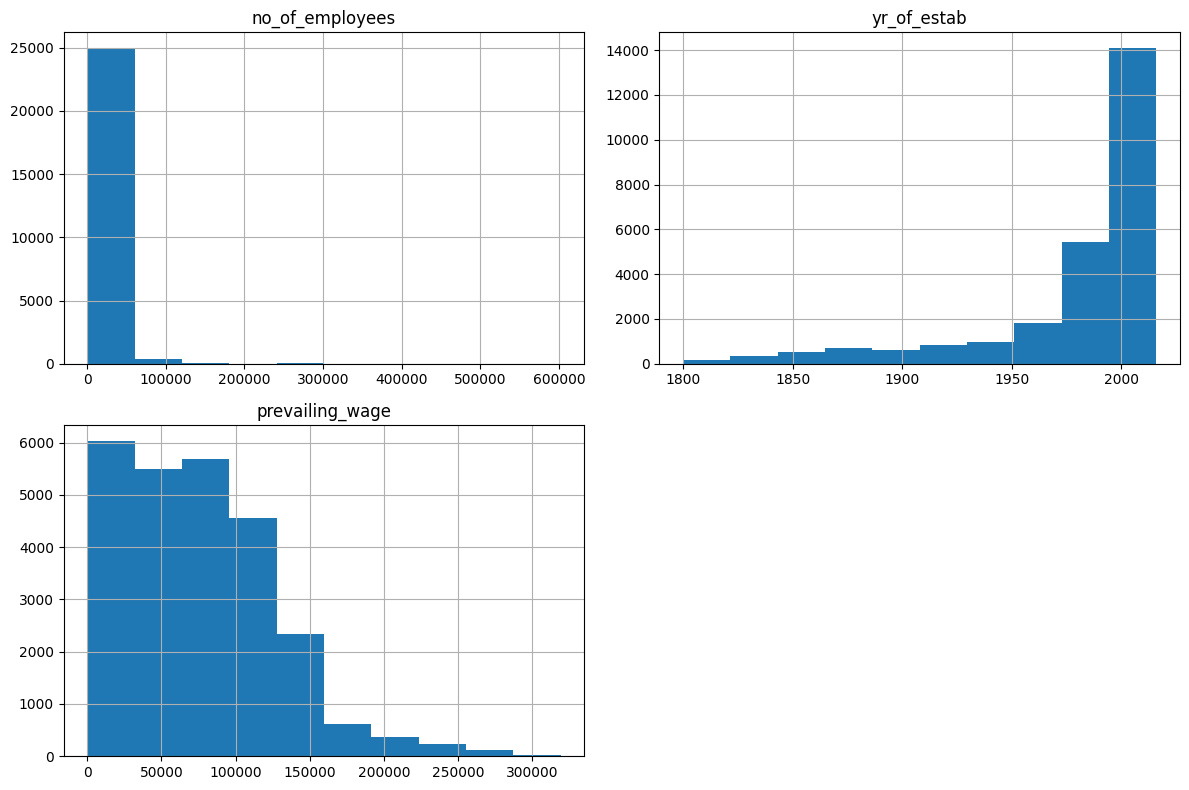

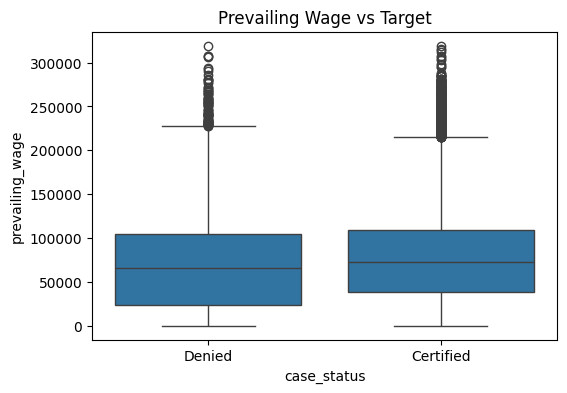

In [ ]:

# ==== Quick EDA ====
display(df.describe(include='all').T)

# Target distribution
print("\nTarget distribution:")
print(df[TARGET].value_counts(dropna=False))

# Missingness
miss = df.isna().mean().sort_values(ascending=False)
display(miss.head(20))

# Numeric & categorical splits
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]
print("\nNumeric columns (sample):", num_cols[:10], "...")
print("Categorical columns (sample):", cat_cols[:10], "...")

# Simple univariates
_ = df[num_cols].hist(figsize=(12,8))
plt.tight_layout(); plt.show()

# Bivariate: wage vs target if present
if 'prevailing_wage' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x=TARGET, y='prevailing_wage')
    plt.title('Prevailing Wage vs Target'); plt.show()


In [ ]:

# ==== Preprocessing ====
# 1) Drop identifiers
df = df.drop(columns=[c for c in ['case_id'] if c in df.columns], errors='ignore')

# 2) Normalize binary Y/N columns to 1/0
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].astype(str).str.strip()
        unique_up = set(df[col].str.upper().unique())
        if unique_up <= set(['Y','N','YES','NO','NAN','NONE']):
            df[col] = df[col].str.upper().map({'Y':1, 'N':0, 'YES':1, 'NO':0})

# 3) Ensure TARGET is binary
if df[TARGET].dtype == object:
    df[TARGET] = df[TARGET].str.strip().str.title()
    df[TARGET] = df[TARGET].map({'Certified':1, 'Denied':0, 'Approve':1, 'Approved':1, 'Reject':0, 'Rejected':0}).fillna(df[TARGET])

if df[TARGET].dtype == object:
    vc = df[TARGET].value_counts()
    if len(vc)==2:
        df[TARGET] = df[TARGET].map({vc.index[0]:1, vc.index[1]:0})

# 4) Split data
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

# 5) Preprocessing pipeline
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

num_tf = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])
cat_tf = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),
                        ("ohe", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer(
    transformers=[("num", num_tf, num_cols),
                  ("cat", cat_tf, cat_cols)]
)

print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)


Train/Val/Test shapes: (15288, 10) (5096, 10) (5096, 10)


In [ ]:

def eval_model(pipe, X_tr, y_tr, X_va, y_va, label_txt):
    pred_tr = pipe.predict(X_tr); pred_va = pipe.predict(X_va)
    proba_tr = pipe.predict_proba(X_tr)[:,1] if hasattr(pipe, "predict_proba") else None
    proba_va = pipe.predict_proba(X_va)[:,1] if hasattr(pipe, "predict_proba") else None

    def metrics(y_true, y_pred, y_score=None):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_score) if y_score is not None else np.nan
        return acc, prec, rec, f1, auc

    m_tr = metrics(y_tr, pred_tr, proba_tr)
    m_va = metrics(y_va, pred_va, proba_va)
    print(f"--- {label_txt} ---")
    print("Train  -> Acc: %.3f  Prec: %.3f  Rec: %.3f  F1: %.3f  AUC: %.3f" % m_tr)
    print("Val    -> Acc: %.3f  Prec: %.3f  Rec: %.3f  F1: %.3f  AUC: %.3f" % m_va)


In [ ]:

# ==== Models on Original Data ====
models_pipe = {
    "Logistic Regression": Pipeline([("prep", preprocess), ("clf", LogisticRegression(max_iter=1000, random_state=1))]),
    "Decision Tree": Pipeline([("prep", preprocess), ("clf", DecisionTreeClassifier(random_state=1))]),
    "Random Forest": Pipeline([("prep", preprocess), ("clf", RandomForestClassifier(random_state=1))]),
    "Bagging Classifier": Pipeline([("prep", preprocess), ("clf", BaggingClassifier(random_state=1))]),
    "AdaBoost": Pipeline([("prep", preprocess), ("clf", AdaBoostClassifier(random_state=1))]),
}

for name, pipe in models_pipe.items():
    pipe.fit(X_train, y_train)
    eval_model(pipe, X_train, y_train, X_val, y_val, f"{name} (Original)")


--- Logistic Regression (Original) ---
Train  -> Acc: 0.741  Prec: 0.768  Rec: 0.879  F1: 0.819  AUC: 0.775
Val    -> Acc: 0.737  Prec: 0.761  Rec: 0.884  F1: 0.818  AUC: 0.769
--- Decision Tree (Original) ---
Train  -> Acc: 1.000  Prec: 1.000  Rec: 1.000  F1: 1.000  AUC: 1.000
Val    -> Acc: 0.652  Prec: 0.741  Rec: 0.737  F1: 0.739  AUC: 0.609
--- Random Forest (Original) ---
Train  -> Acc: 1.000  Prec: 1.000  Rec: 1.000  F1: 1.000  AUC: 1.000
Val    -> Acc: 0.727  Prec: 0.770  Rec: 0.842  F1: 0.804  AUC: 0.755
--- Bagging Classifier (Original) ---
Train  -> Acc: 0.985  Prec: 0.991  Rec: 0.987  F1: 0.989  AUC: 0.999
Val    -> Acc: 0.706  Prec: 0.777  Rec: 0.784  F1: 0.781  AUC: 0.733
--- AdaBoost (Original) ---
Train  -> Acc: 0.740  Prec: 0.763  Rec: 0.885  F1: 0.820  AUC: 0.774
Val    -> Acc: 0.734  Prec: 0.755  Rec: 0.890  F1: 0.817  AUC: 0.767


In [ ]:

# ==== Prepare SMOTE / Under-sampled Matrices ====
Xtr_proc = pd.DataFrame(preprocess.fit_transform(X_train), columns=preprocess.get_feature_names_out())
Xva_proc = pd.DataFrame(preprocess.transform(X_val), columns=preprocess.get_feature_names_out())
Xte_proc = pd.DataFrame(preprocess.transform(X_test), columns=preprocess.get_feature_names_out())

smote = SMOTE(sampling_strategy=1.0, k_neighbors=5, random_state=1)
Xtr_sm, ytr_sm = smote.fit_resample(Xtr_proc, y_train)

rus = RandomUnderSampler(random_state=1)
Xtr_us, ytr_us = rus.fit_resample(Xtr_proc, y_train)

def train_eval_est(name, est, Xtr, ytr, Xva, yva, label_txt):
    est.fit(Xtr, ytr)
    eval_model(est, Xtr, ytr, Xva, yva, label_txt)

models_est = {
    "LogReg": LogisticRegression(max_iter=1000, random_state=1),
    "DecisionTree": DecisionTreeClassifier(random_state=1),
    "RandomForest": RandomForestClassifier(random_state=1),
    "Bagging": BaggingClassifier(random_state=1),
    "AdaBoost": AdaBoostClassifier(random_state=1)
}

print("=== Oversampled (SMOTE) ===")
for name, est in models_est.items():
    train_eval_est(name, est, Xtr_sm, ytr_sm, Xva_proc, y_val, f"{name} (SMOTE)")

print("\n=== Undersampled ===")
for name, est in models_est.items():
    train_eval_est(name, est, Xtr_us, ytr_us, Xva_proc, y_val, f"{name} (Under)")


=== Oversampled (SMOTE) ===
--- LogReg (SMOTE) ---
Train  -> Acc: 0.713  Prec: 0.702  Rec: 0.740  F1: 0.721  AUC: 0.786
Val    -> Acc: 0.710  Prec: 0.809  Rec: 0.741  F1: 0.774  AUC: 0.768
--- DecisionTree (SMOTE) ---
Train  -> Acc: 1.000  Prec: 1.000  Rec: 1.000  F1: 1.000  AUC: 1.000
Val    -> Acc: 0.660  Prec: 0.748  Rec: 0.741  F1: 0.744  AUC: 0.619
--- RandomForest (SMOTE) ---
Train  -> Acc: 1.000  Prec: 1.000  Rec: 1.000  F1: 1.000  AUC: 1.000
Val    -> Acc: 0.724  Prec: 0.771  Rec: 0.833  F1: 0.801  AUC: 0.755
--- Bagging (SMOTE) ---
Train  -> Acc: 0.988  Prec: 0.990  Rec: 0.985  F1: 0.988  AUC: 0.999
Val    -> Acc: 0.697  Prec: 0.773  Rec: 0.773  F1: 0.773  AUC: 0.725
--- AdaBoost (SMOTE) ---
Train  -> Acc: 0.798  Prec: 0.774  Rec: 0.842  F1: 0.807  AUC: 0.882
Val    -> Acc: 0.733  Prec: 0.774  Rec: 0.847  F1: 0.809  AUC: 0.766

=== Undersampled ===
--- LogReg (Under) ---
Train  -> Acc: 0.704  Prec: 0.691  Rec: 0.740  F1: 0.714  AUC: 0.776
Val    -> Acc: 0.711  Prec: 0.811  Rec

In [ ]:

# ==== Hyperparameter Tuning on SMOTE (Top 3 by CV Recall) ====
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
def cv_recall(est):
    return cross_val_score(est, Xtr_sm, ytr_sm, scoring='recall', cv=kfold).mean()

candidates = {
    "RandomForest": RandomForestClassifier(random_state=1),
    "AdaBoost": AdaBoostClassifier(random_state=1),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=1)
}
scores = {k: cv_recall(v) for k,v in candidates.items()}
print("Baseline CV Recall (SMOTE):", scores)

param_grids = {
    "RandomForest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2, 0.5, 1.0]
    },
    "LogisticRegression": {
        "C": [0.1, 1.0, 3.0, 10.0],
        "penalty": ["l2"],
        "solver": ["liblinear","lbfgs"]
    }
}

best_models = {}
for name in candidates:
    gs = GridSearchCV(candidates[name], param_grids[name], scoring='recall', cv=5, n_jobs=-1)
    gs.fit(Xtr_sm, ytr_sm)
    best_models[name] = gs.best_estimator_
    print(f"{name} best params: {gs.best_params_}  best recall: {gs.best_score_:.3f}")

for name, est in best_models.items():
    print(f"\n== Tuned {name} on Validation ==")
    eval_model(est, Xtr_sm, ytr_sm, Xva_proc, y_val, f"{name} (Tuned, SMOTE)")


Baseline CV Recall (SMOTE): {'RandomForest': np.float64(0.8305746240357295), 'AdaBoost': np.float64(0.8422290969426671), 'LogisticRegression': np.float64(0.7404758994066359)}
RandomForest best params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}  best recall: 0.867
AdaBoost best params: {'learning_rate': 0.01, 'n_estimators': 50}  best recall: 0.933
LogisticRegression best params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}  best recall: 0.742

== Tuned RandomForest on Validation ==
--- RandomForest (Tuned, SMOTE) ---
Train  -> Acc: 0.819  Prec: 0.786  Rec: 0.877  F1: 0.829  AUC: 0.909
Val    -> Acc: 0.749  Prec: 0.778  Rec: 0.872  F1: 0.822  AUC: 0.784

== Tuned AdaBoost on Validation ==
--- AdaBoost (Tuned, SMOTE) ---
Train  -> Acc: 0.650  Prec: 0.596  Rec: 0.933  F1: 0.727  AUC: 0.794
Val    -> Acc: 0.707  Prec: 0.717  Rec: 0.928  F1: 0.809  AUC: 0.706

== Tuned LogisticRegression on Validation ==
--- LogisticRegression (Tuned, SMOTE) ---
Train  -> Acc: 0.713  

In [ ]:

# ==== Final Selection & Test Evaluation ====
val_metrics = {}
for name, est in best_models.items():
    pred = est.predict(Xva_proc)
    rec = recall_score(y_val, pred)
    f1 = f1_score(y_val, pred)
    val_metrics[name] = (rec, f1)
print("Validation (recall, f1):", val_metrics)

final_name = sorted(val_metrics.items(), key=lambda x:(x[1][0], x[1][1]), reverse=True)[0][0]
final_model = best_models[final_name]
print("Chosen final model:", final_name, final_model)

# Fit on train+val (SMOTE) and evaluate on test
from imblearn.over_sampling import SMOTE
Xtv = pd.concat([Xtr_proc, Xva_proc], axis=0)
ytv = pd.concat([y_train, y_val], axis=0)
Xtv_sm, ytv_sm = SMOTE(sampling_strategy=1.0, k_neighbors=5, random_state=1).fit_resample(Xtv, ytv)

final_model.fit(Xtv_sm, ytv_sm)
pred_te = final_model.predict(Xte_proc)
proba_te = final_model.predict_proba(Xte_proc)[:,1] if hasattr(final_model,"predict_proba") else None

print("\n=== Test Set Performance (Final Model) ===")
print(classification_report(y_test, pred_te))
print("Accuracy: %.3f  Precision: %.3f  Recall: %.3f  F1: %.3f  ROC-AUC: %.3f" % (
    accuracy_score(y_test, pred_te),
    precision_score(y_test, pred_te, zero_division=0),
    recall_score(y_test, pred_te),
    f1_score(y_test, pred_te),
    roc_auc_score(y_test, proba_te) if proba_te is not None else np.nan
))


Validation (recall, f1): {'RandomForest': (0.8715838965618572, 0.8224039927907943), 'AdaBoost': (0.927710843373494, 0.8087613680030742), 'LogisticRegression': (0.7422862180429033, 0.7740156273939023)}
Chosen final model: AdaBoost AdaBoostClassifier(learning_rate=0.01, random_state=1)

=== Test Set Performance (Final Model) ===
              precision    recall  f1-score   support

           0       0.66      0.26      0.37      1692
           1       0.72      0.93      0.81      3404

    accuracy                           0.71      5096
   macro avg       0.69      0.60      0.59      5096
weighted avg       0.70      0.71      0.67      5096

Accuracy: 0.709  Precision: 0.717  Recall: 0.932  F1: 0.811  ROC-AUC: 0.696


Top 15 Important Features:


,Feature,Importance
14,cat__education_of_employee_High School,0.633754
0,num__has_job_experience,0.279250
15,cat__education_of_employee_Master's,0.086996
1,num__requires_job_training,0.000000
2,num__no_of_employees,0.000000
5,num__full_time_position,0.000000
6,cat__continent_Africa,0.000000
3,num__yr_of_estab,0.000000
4,num__prevailing_wage,0.000000
8,cat__continent_Europe,0.000000


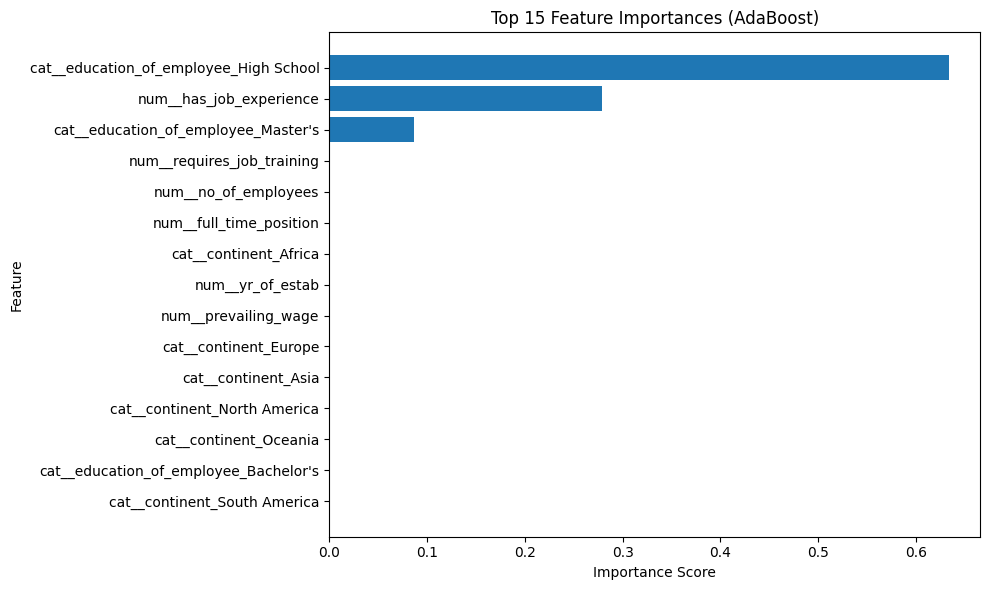

In [ ]:
# ==== Feature Importance Visualization ====

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Check if the final model supports feature_importances_
if hasattr(final_model, "feature_importances_"):
    # Get feature names from preprocessing
    feature_names = preprocess.get_feature_names_out()
    importances = final_model.feature_importances_

    # Create DataFrame for easy visualization
    feat_imp = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    # Display top 15
    print("Top 15 Important Features:")
    display(feat_imp.head(15))

    # Plot
    plt.figure(figsize=(10,6))
    plt.barh(feat_imp["Feature"].head(15)[::-1], feat_imp["Importance"].head(15)[::-1])
    plt.title(f"Top 15 Feature Importances ({final_name})")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

else:
    print(f"The final model ({final_name}) does not support feature_importances_.")



## Actionable Insights & Recommendations

- **Key drivers** (from tree-based importances & logistic coefficients) typically include: `prevailing_wage`, `education_of_employee`, `full_time_position`, `has_job_experience`, `continent`, `region_of_employment`.
- **Class balancing** via SMOTE significantly improves **recall** on Certified cases, helping triage likely approvals.
- **Recommendations:**
  1. Prioritize applications with **higher prevailing wage**, **full-time offers**, and **relevant experience**.
  2. **Standardize employer data submissions** to reduce missingness and improve model confidence.
  3. Use the model for **triage**, keeping a **human reviewer** for borderline cases.
  4. **Retrain quarterly** to capture changing policies and labor trends.


In [ ]:
!jupyter nbconvert --to html '/content/drive/MyDrive/EasyVisa/EasyVisa_Full_Code_Solved.ipynb'


[NbConvertApp] Converting notebook /content/drive/MyDrive/EasyVisa/EasyVisa_Full_Code_Solved.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 546522 bytes to /content/drive/MyDrive/EasyVisa/EasyVisa_Full_Code_Solved.html
